In [1]:
import sys
sys.path.append("..") 
import numpy as np

import matplotlib.pyplot as plt 
from sgd_framework.sgd import SGD
from sgd_framework.parameter_estimator import ParameterEstimator
from sgd_framework.regression_model import RegressionModel
from data.generate_synthetic_data import transform_to_polynomial, generate_training_data_fixed
from sklearn.model_selection import train_test_split
from sgd_framework.twolayer_nn import TwoLayerNNModel
from sgd_framework.nonconvex_sgd import NonConvexSGD, FixedStepsize, DiminishingStepsize

In [2]:
np.random.seed(0)
X_raw, _, _ = generate_training_data_fixed(m=1000, n=2, noise=0.01)
X_poly = transform_to_polynomial(X_raw, degree=3, normalize=True)

true_A = 0.001 * np.arange(1, X_poly.shape[1] + 1)
true_b = 1.0
noise = 0.01
y = X_poly @ true_A + true_b + np.random.normal(0, noise, size=X_poly.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)


# PR fixed
poly_model_fixed = RegressionModel(X_train, y_train)
sgd_fixed_poly = SGD(poly_model_fixed, num_iterations=1000, batch_size=1, noise=noise, stepsize_type='fixed')
w_fixed_poly, *_ = sgd_fixed_poly.optimize()
poly_test_pred = X_test @ w_fixed_poly[1:] + w_fixed_poly[0]
poly_mse_fixed = np.mean((poly_test_pred- y_test) ** 2)


#  PR diminishing
poly_model_diminish = RegressionModel(X_train, y_train)
sgd_diminish_poly = SGD(poly_model_diminish, num_iterations=1000, batch_size=1, noise=noise, stepsize_type='diminishing')
w_diminish_poly, *_ = sgd_diminish_poly.optimize()
poly_test_pred_diminish = X_test @ w_diminish_poly[1:] + w_diminish_poly[0]
poly_mse_diminish = np.mean((poly_test_pred_diminish- y_test) ** 2)

In [3]:
alpha = sgd_fixed_poly.strategy.alpha
beta = sgd_diminish_poly.strategy.beta
gamma = sgd_diminish_poly.strategy.gamma

In [4]:
hidden_sizes = [1, 5, 10, 20, 50]
nn_mse_fixed = []
nn_mse_diminish = []
for h in hidden_sizes:
    print(f"Training NN with {h} hidden sizes fixed stepsize")
    nn_fixed = TwoLayerNNModel(input_dim=X_train.shape[1], hidden_dim=h)
    fixed_type = FixedStepsize(alpha=alpha)
    sgd_fixed = NonConvexSGD(nn_fixed, X_train, y_train, num_iterations=1000, batch_size=1, stepsize_type=fixed_type)
    w_fixed, _, _ = sgd_fixed.optimize()
    preds_fixed = np.array([nn_fixed.forward(x, w_fixed) for x in X_test])
    mse_fixed = np.mean((preds_fixed - y_test) ** 2)
    nn_mse_fixed.append(mse_fixed)

    print(f"Training NN with {h} hidden sizes diminishing stepsize")
    nn_diminish = TwoLayerNNModel(input_dim=X_train.shape[1], hidden_dim=h)
    diminish_type = DiminishingStepsize(beta=beta, gamma=gamma)  
    sgd_diminish = NonConvexSGD(nn_diminish, X_train, y_train, num_iterations=1000, batch_size=1, stepsize_type=diminish_type)
    w_diminish, _, _ = sgd_diminish.optimize()
    preds_diminish = np.array([nn_diminish.forward(x, w_diminish) for x in X_test])
    mse_diminish = np.mean((preds_diminish - y_test) ** 2)
    nn_mse_diminish.append(mse_diminish)

Training NN with 1 hidden sizes fixed stepsize
Training NN with 1 hidden sizes diminishing stepsize
Training NN with 5 hidden sizes fixed stepsize
Training NN with 5 hidden sizes diminishing stepsize
Training NN with 10 hidden sizes fixed stepsize
Training NN with 10 hidden sizes diminishing stepsize
Training NN with 20 hidden sizes fixed stepsize
Training NN with 20 hidden sizes diminishing stepsize
Training NN with 50 hidden sizes fixed stepsize


/Users/ericabrown/scie30001/experiments/../sgd_framework/twolayer_nn.py:46: RuntimeWarning: overflow encountered in matmul
  h2 = W2 @ z1 + b2
/Users/ericabrown/scie30001/experiments/../sgd_framework/twolayer_nn.py:51: RuntimeWarning: overflow encountered in square
  return np.mean((preds - y) ** 2)
/Users/ericabrown/scie30001/experiments/../sgd_framework/twolayer_nn.py:72: RuntimeWarning: overflow encountered in matmul
  h2 = W2 @ z1 + b2
/Users/ericabrown/scie30001/experiments/../sgd_framework/twolayer_nn.py:76: RuntimeWarning: invalid value encountered in multiply
  dW2 = error * z1.T
/Users/ericabrown/scie30001/experiments/../sgd_framework/twolayer_nn.py:80: RuntimeWarning: invalid value encountered in multiply
  e1 = (W2.T * error) * D1
/Users/ericabrown/scie30001/experiments/../sgd_framework/twolayer_nn.py:76: RuntimeWarning: overflow encountered in multiply
  dW2 = error * z1.T
/Users/ericabrown/scie30001/experiments/../sgd_framework/twolayer_nn.py:80: RuntimeWarning: overflow e

Training NN with 50 hidden sizes diminishing stepsize


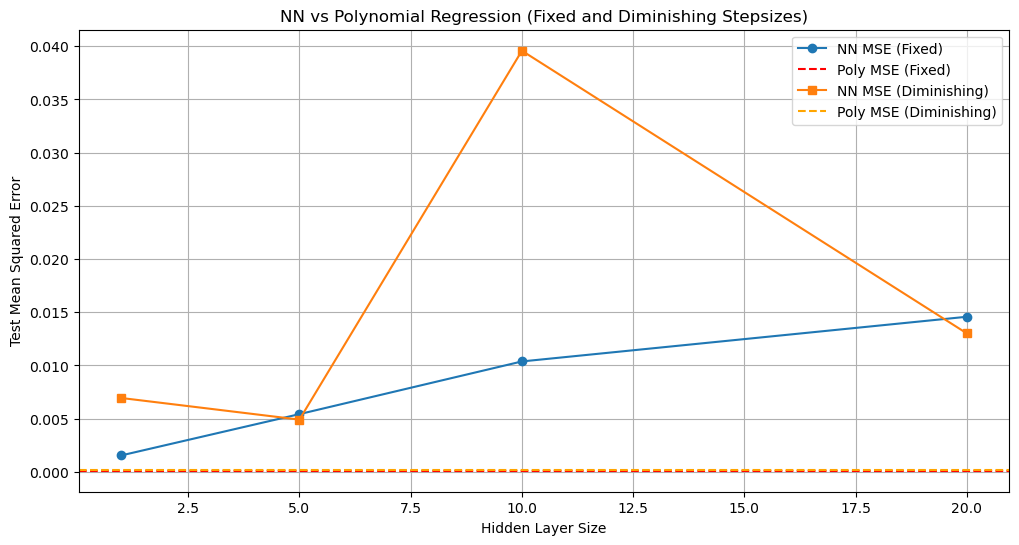

In [5]:
plt.figure(figsize=(12, 6))

# Fixed
plt.plot(hidden_sizes, nn_mse_fixed, marker='o', label='NN MSE (Fixed)')
plt.axhline(poly_mse_fixed, color='r', linestyle='--', label='Poly MSE (Fixed)')

# Diminishing
plt.plot(hidden_sizes, nn_mse_diminish, marker='s', label='NN MSE (Diminishing)')
plt.axhline(poly_mse_diminish, color='orange', linestyle='--', label='Poly MSE (Diminishing)')

plt.xlabel('Hidden Layer Size')
plt.ylabel('Test Mean Squared Error')
plt.title('NN vs Polynomial Regression (Fixed and Diminishing Stepsizes)')
plt.legend()
plt.grid(True)
plt.show()
